# Analysis of Boston/SeattleAirbnb Data

This project investigates Airbnb Data from Boston and Seattle.  

## Main Questions of the Project:
 
1) Which factors correlate with a high rental price for an object? How well can they predict the rental price?  
2) Can the factors that work in Boston predict prices in Seattle? Can the factors that work in Seattle predict prices in Boston?  
3) How well do the review scores match the NLTK language processing scores?  

## This Notebook: Modelling and Analysis

First I start off by loading the necessary data and packages

In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import pyarrow
from regressors import stats

%matplotlib inline

# Load in the Data from the cleaned parquets
boston_calendar = pd.read_parquet('./boston_calendar_cleaned')
boston_listings = pd.read_parquet('./boston_listings_cleaned')
boston_reviews = pd.read_parquet('./boston_reviews_cleaned')
seattle_calendar = pd.read_parquet('./seattle_calendar_cleaned')
seattle_listings = pd.read_parquet('./seattle_listings_cleaned')
seattle_reviews = pd.read_parquet('./seattle_reviews_cleaned')

## Question 1: Which factors correlate with a high rental price for an object? How well can they predict the rental price?   
To address this question, I use the listings data together with the reviews that have been analyzed using the NLTK package. The data lacks a bit of documentation, whether the final price is equal to price + cleaning charge or if the cleaning charge is already included in the price. I will assume that the final price, that a customer pays is equal to price + cleaning charge.  

To find the factors that correlate most closely with the rental price of an object, I will use the LASSO technique (elastic net with L1 norm only). This will allow me to employ a data driven approach the reduce the number of possible factors from 69 to a more managable number.


In [2]:
# Functions to run the necessary analysis for question 1 on the boston and seattle data sets

def data_prep(listings_clean,reviewscores_clean):
    # Drop the id of the Airbnb for purpose of regression
    listings_use=listings_clean.drop(['id'],axis=1)
    # Define the final price as price + cleaning_fee
    final_price = listings_clean.price+listings_clean.cleaning_fee
    # Drop the price and cleaning fee columns
    listings_use=listings_clean.drop(['price','cleaning_fee'],axis=1)
    # Add review scores from language processing
    avg_scores=reviewscores_clean.groupby('listing_id').mean()
    listings_use = listings_use.merge(avg_scores, left_on='id',right_on='listing_id',how='left')
    # Fill in NaN's from language processing with averages
    listings_use.isna().sum()
    fill_mean = lambda col: col.fillna(col.mean())
    listings_use=listings_use.apply(fill_mean, axis=0)
    # Define X and y
    y=final_price
    X=listings_use
    return X,y

def question1_analysis(X,y):
    # Split data set into test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    # Fit the model
    lasso_model = Lasso(normalize=True)
    lasso_model.fit(X_train,y_train)
    # Get model predictions
    y_train_preds = lasso_model.predict(X_train)
    y_test_preds = lasso_model.predict(X_test) 
    #Obtain an rsquared value for both the training and test data
    train_score=r2_score(y_train, y_train_preds)
    test_score=r2_score(y_test, y_test_preds)
    relevant_factors = X.columns[abs(lasso_model.coef_)>0]
    return train_score, test_score, relevant_factors, lasso_model

In [3]:
# Run the regression model for the boston dataset
X_boston,y_boston = data_prep(boston_listings,boston_reviews)
boston_train_score, boston_test_score, boston_model_coefs, boston_model = question1_analysis(X_boston,y_boston)
# Results print('{:.2f}'.format(5.39120))
print('Boston Train Score:', '{:.2f}'.format(boston_train_score), 'Boston Test Score:', '{:.2f}'.format(boston_test_score))
print('Most important factors for price prediction:', boston_model_coefs.values)

Boston Train Score: 0.23 Boston Test Score: 0.18
Most important factors for price prediction: ['accommodates' 'room_type_Private room']


In [4]:
# Run the regression model for the seattle dataset
X_seattle,y_seattle = data_prep(seattle_listings,seattle_reviews)
seattle_train_score, seattle_test_score, seattle_model_coefs, seattle_model = question1_analysis(X_seattle,y_seattle)
# Results
print('Seattle Train Score:', '{:.2f}'.format(seattle_train_score), 'Seattle Test Score:', '{:.2f}'.format(seattle_test_score))
print('Most important factors for price prediction:', seattle_model_coefs.values)

Seattle Train Score: 0.34 Seattle Test Score: 0.36
Most important factors for price prediction: ['accommodates' 'bedrooms']


In Boston the LASSO model has chosen 'accomodates', i.e. how many people an appartment can accomodate, and 'room_type_Private room', i.e. whether or not a room is a private room as the two most important factors to predict the price of an Airbnb listing.  

In Seattle the LASSO model has chosen 'accomodates', i.e. how many people an appartmante can accomodate, and 'bedrooms', i.e. how many bedrooms an appartment has as the two most important factors to predict the price of an Airbnb listing.  

We can see that the models are still having a hard time to predict the prices. The training r2score in Boston is 0.23, while the testing r2score is 0.18. In Seattle the training r2score is 0.34 while the testing r2score is 0.36.  

# Question 2: Can the factors that work in Boston predict prices in Seattle? Can the factors that work in Seattle predict Boston?

In [5]:
# Using the boston model to predict for seattle
boston_model_rel_coefs = boston_model.coef_[abs(boston_model.coef_)>0]
boston_predict_seattle = boston_model_rel_coefs[0]*X_seattle.accommodates+ boston_model_rel_coefs[1]*X_seattle['room_type_Private room']+ boston_model.intercept_
test_score_bPs = r2_score(y_seattle,boston_predict_seattle)
print('Boston predicting Seattle r2score:', '{:.2f}'.format(test_score_bPs))

Boston predicting Seattle r2score: 0.16


In [6]:
# Using the Seattle model to predict for Boston
seattle_model_rel_coefs = seattle_model.coef_[abs(seattle_model.coef_)>0]
seattle_predict_boston = seattle_model_rel_coefs[0]*X_boston.accommodates+ seattle_model_rel_coefs[1]*X_boston['bedrooms']+ seattle_model.intercept_
test_score_sPb = r2_score(y_boston,seattle_predict_boston)
print('Seattle predicting Boston r2score:', '{:.2f}'.format(test_score_sPb))

Seattle predicting Boston r2score: 0.06


In the first question we had seen that the models both picked up on the number of people an Airbnb can accommodate as an important factor to predict the price. When using the Boston model to predict prices in Seattle, the r2score is 0.16, compared to a r2score of 0.36 that the Seattle model scores in predicting its own prices. This suggests that the Boston and Seattle market are still quite different.  

Similarly, when using the Seattle model to predict the Boston market the r2score is only 0.06, compared to a r2score of 0.18 that the Boston model offers in predicting its own prices. This strengthens the suspicion that the Boston and Seattle markets are quite different.

## Question 3: How well do the review scores match the NLTK language processing scores?

Residuals:
     Min      1Q  Median     3Q     Max
-27.9744 -4.2947 -1.5206 3.1544 58.3024


Coefficients:
             Estimate  Std. Error   t value  p value
_intercept  76.164449    0.495886  153.5928      0.0
compound    20.458740    0.699826   29.2340      0.0
---
R-squared:  0.23682,    Adjusted R-squared:  0.23643
F-statistic: 613.78 on 1 features
Boston
Train Score Review Scores on NLTK Compound: 0.24 Test Score Review Scores on NLTK Compound: 0.14


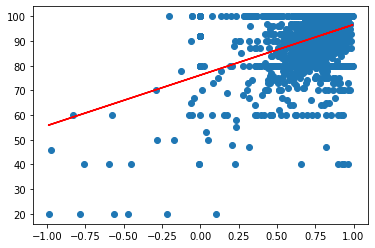

In [16]:
# Function to prepare the data and run a simple OLS regression on the review scores vs the compound scores of NLTK
def review_score_regression(listings,reviews):
    # Select the review scores and the compound rating of the written reviews from the data
    scores_only = listings[['id','review_scores_rating']]
    avg_compound = reviews.groupby('listing_id').compound.mean()
    scores_merged = scores_only.merge(avg_compound, left_on='id',right_on='listing_id',how='left')
    # Drop the places that do not have a written review
    scores_merged.dropna(inplace=True)
    # Define X and y of the regression
    X_scores = scores_merged['compound'].values.reshape(-1,1)
    y_scores = scores_merged['review_scores_rating'].values
    # Split data set into test and train
    X_scores_train, X_scores_test, y_scores_train, y_scores_test = train_test_split(X_scores, y_scores, test_size = .30, random_state=42)
    scores_analysis = LinearRegression(normalize=True)
    scores_analysis.fit(X_scores_train,y_scores_train)
    # Get model predictions
    y_train_preds = scores_analysis.predict(X_scores_train)
    y_test_preds = scores_analysis.predict(X_scores_test) 
    #Obtain an rsquared value for both the training and test data
    train_score=r2_score(y_scores_train, y_train_preds)
    test_score=r2_score(y_scores_test, y_test_preds)
    # Provide a scatter plot of X and y
    plot = plt.figure()
    plt.scatter(x=X_scores, y=y_scores);
    plt.plot(X_scores_train,y_train_preds, color='r')
    plt.close()
    # calculate p value of the coefficient
    pvals = stats.summary(scores_analysis, X_scores_train, y_scores_train,['compound']);
    return train_score, test_score, plot, pvals

# Run the analysis for boston
train_score, test_score , boston_plot, boston_pvals= review_score_regression(boston_listings,boston_reviews)
# Print the results
print('Boston')
print('Train Score Review Scores on NLTK Compound:' ,'{:.2f}'.format(train_score),'Test Score Review Scores on NLTK Compound:' ,'{:.2f}'.format(test_score))
boston_plot


Residuals:
     Min     1Q  Median     3Q    Max
-29.4427 -3.447 -1.2103 1.8101 56.905


Coefficients:
             Estimate  Std. Error   t value  p value
_intercept  77.260637     0.59244  130.4109      0.0
compound    19.820765     0.73592   26.9333      0.0
---
R-squared:  0.17021,    Adjusted R-squared:  0.16983
F-statistic: 457.62 on 1 features
Seattle
Train Score Review Scores on NLTK Compound: 0.17 Test Score Review Scores on NLTK Compound: 0.07


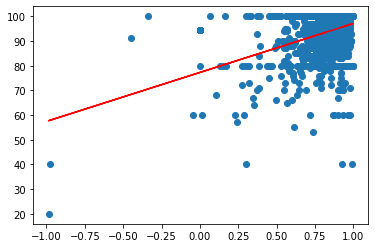

In [17]:
# Run the analysis for seattle
train_score, test_score , seattle_plot, seattle_pvals= review_score_regression(seattle_listings,seattle_reviews)
# Print the results
print('Seattle')
print('Train Score Review Scores on NLTK Compound:' ,'{:.2f}'.format(train_score),'Test Score Review Scores on NLTK Compound:' ,'{:.2f}'.format(test_score))
seattle_plot

The Boston r2score on the test data is only 0.14, the Seattle r2score on the test data is only 0.07. Therefore the NLTK compound score does not predict the review scores rating of the listings particularly well. However, in both regressions the p-value is very small. Therefore the relationship between the NLTK score and the rating of an Airbnb is highly significant.

The low predictive power stems most likely from the fact that one explanatory variable simply does not offer enough variation to predict the ratings scores